In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
#from nltk.corpus import stopwords
import nltk
import re
from tabulate import tabulate
from tqdm import trange

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

c:\Users\Leo\.conda\envs\bert\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#verificare la disponibilità di cuda
#import os 
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
n_gpu = torch.cuda.device_count()
print(torch.cuda.get_device_name(0))
print(device)

NVIDIA GeForce GTX 1080 Ti
cuda:0


## PRE PROCESSING

In [3]:
df = pd.read_csv("./data.csv")
df.head()

,Unnamed: 0,text,label
0,0,i feel awful about it too because it s my job ...,0
1,1,im alone i feel awful,0
2,2,ive probably mentioned this before but i reall...,1
3,3,i was feeling a little low few days back,0
4,4,i beleive that i am much more sensitive to oth...,2


In [4]:
df.drop('Unnamed: 0', inplace=True, axis=1)
df = df.dropna()
df['label'] = df['label'].astype(int)

In [5]:
df.head()

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2


In [6]:
#df['label'] = df['label'].replace([3], 2)
#df['label'] = df['label'].replace([4], 3)
#df['label'] = df['label'].replace([5], 4)

In [7]:
print(df['label'].unique())

[0 1 2 3 4 5]


In [8]:
def shuffle(df, n=3, axis=0):     
    df = df.copy()
    random_states = [2,42,4]
    for i in range(n):
        df = df.sample(frac=1,random_state=random_states[i]) # mischio il dataframe 
    return df

new_df = shuffle(df)
new_df

,text,label
305419,i lived her life without the feeling of accept...,3
313179,i feel ungrateful to be sneezing snuffling and...,0
359630,i cannot help but be completely enamoured and ...,0
386791,im feeling pretty horny chuckles,2
109071,i feel almost like im supporting a non profit ...,1
...,...,...
69327,i feel particularly tortured over a decision t...,3
280140,i is in fact a vampire however the little boy ...,4
207763,i feel like i don t belong i want to make more...,1
265300,i have no strong feeling that the earth moves ...,1


## Elimino le stopwords

In [9]:
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('english')

def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) #Comando che permette di cambiare tutti i caratteri tranne :a-z, A-Z, ".", "?", "!", "," con uno spazio 

    text = re.sub(r"http\S+", "",text) #Rimozione dei link 
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Rimozione dei tag HTML
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Comando che permette di rimuovere i segni definiti sopra come punteggiatura
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = " ".join(text) #Rimozione di tutte le stopword
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Comando che rimuove quelle definite sopra come emojis
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Leo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# rimozione delle stopword
df['text'] = df['text'].apply(lambda x: clean_text(x))

## TRAIN TEST SPLIT

In [11]:
split_idx = int(len(df)*0.8)

train_df = new_df.loc[:split_idx,:]
test_df = new_df.loc[split_idx:,:]
print('train lenght:',len(train_df))
print(train_df.groupby(['label'])['text'].count())
print('test lenght:',len(test_df))
print(test_df.groupby(['label'])['text'].count())

train lenght: 180816
label
0    52647
1    61287
2    14821
3    24894
4    20709
5     6458
Name: text, dtype: int64
test lenght: 235994
label
0    68541
1    79780
2    19733
3    32423
4    27003
5     8514
Name: text, dtype: int64


In [12]:
sentences = train_df.text
labels = list(train_df.label)

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

## Esempio di tokenizzazione

In [14]:
index=0
print(' Original: ', list(sentences)[index])
table = np.array([tokenizer.tokenize(list(sentences)[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(list(sentences)[index]))]).T
print(tabulate(table,headers = ['Tokens', 'Token IDs'],tablefmt = 'fancy_grid'))


 Original:  i lived her life without the feeling of acceptance she felt as though trouble and misery followed her everywhere she went and that everyone hated her because of it
╒════════════╤═════════════╕
│ Tokens     │   Token IDs │
╞════════════╪═════════════╡
│ i          │        1045 │
├────────────┼─────────────┤
│ lived      │        2973 │
├────────────┼─────────────┤
│ her        │        2014 │
├────────────┼─────────────┤
│ life       │        2166 │
├────────────┼─────────────┤
│ without    │        2302 │
├────────────┼─────────────┤
│ the        │        1996 │
├────────────┼─────────────┤
│ feeling    │        3110 │
├────────────┼─────────────┤
│ of         │        1997 │
├────────────┼─────────────┤
│ acceptance │        9920 │
├────────────┼─────────────┤
│ she        │        2016 │
├────────────┼─────────────┤
│ felt       │        2371 │
├────────────┼─────────────┤
│ as         │        2004 │
├────────────┼─────────────┤
│ though     │        2295 │
├───────────

## Add special token

In [15]:
max_len = 0
l=[]
for sent in list(sentences):

    #Tokenizza il testo e aggiunge i tokens `[CLS]` e `[SEP]`
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    #Aggiorna la lunghezza massima delle frasi presenti nel dataset
    l.append(len(input_ids))
    max_len = max(max_len, len(input_ids))

if max_len>512:
  max_len=512
avg_len=int(sum(l)/len(l))

print('Max sentence length: ', max_len)
print('Avg sentence length: ', avg_len)

Max sentence length:  185
Avg sentence length:  22


In [16]:
MAX_LEN = 128
#Tokenizza tutte le frasi e mappa i tokens con i loro IDs
input_ids = []
attention_masks = []

for sent in sentences:
    # Quello che `encode_plus` farà:
    #   1. Tokenizza la frase
    #   2. Aggiunge il token `[CLS]` all'inizio della frase
    #   3. Aggiunge il token `[SEP]` alla fine della frase
    #   4. Mappa il token con il loro ID
    #   5. Esegue il padding o tronca la frase affinche la sua lunghezza sia pari a `max_length`
    #   6. Crea le attention masks per il token [PAD]
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True,      #Aggiunge i tokens '[CLS]' e '[SEP]'
                        max_length = MAX_LEN,           #Setta la lunghezza massima
                        pad_to_max_length = True,       #Se necessaio esegue il padding
                        return_attention_mask = True,   #Costruisce le attn. masks
                        return_tensors = 'pt',          #Restituisce un tensore di pytorch
                   )
    
    #Aggiunge la frase codificata alla lista degli input   
    input_ids.append(encoded_dict['input_ids'])
    
    #E aggiunge le attention mask alla lista (semplice distinzione tra padding o meno)
    attention_masks.append(encoded_dict['attention_mask'])

#Converte la lista in un tensore
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Leo\.conda\envs\bert\lib\site-packages\transformers\tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Esempio di encoding

In [17]:
#Stampa la prima frase come una lista di IDs
i=random.randint(0,len(sentences)-1)
print('Original: ', list(sentences)[i])
print('Input IDs:', input_ids[i])

Original:  i find that i only feel more and more disillusioned with life itself
Input IDs: tensor([  101,  1045,  2424,  2008,  1045,  2069,  2514,  2062,  1998,  2062,
         4487, 27572, 24117,  2098,  2007,  2166,  2993,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,  

In [18]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(sentences) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(input_ids[index]))
  token_ids = [i.numpy() for i in input_ids[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(list(sentences)[index])
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

i rest up a bit im gonna check in on how i feel it might be messy
╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │         101 │                1 │
├──────────┼─────────────┼──────────────────┤
│ i        │        1045 │                1 │
├──────────┼─────────────┼──────────────────┤
│ rest     │        2717 │                1 │
├──────────┼─────────────┼──────────────────┤
│ up       │        2039 │                1 │
├──────────┼─────────────┼──────────────────┤
│ a        │        1037 │                1 │
├──────────┼─────────────┼──────────────────┤
│ bit      │        2978 │                1 │
├──────────┼─────────────┼──────────────────┤
│ im       │       10047 │                1 │
├──────────┼─────────────┼──────────────────┤
│ gonna    │        6069 │                1 │
├──────────┼─────────────┼──────────────────┤
│ check    │        4638 │                1 │
├──────────┼──

## Train Test split

In [19]:
#Creaun unico Dataset (di tensori) unendo i tensori relativi agli input, alle label e alle attention mask
dataset = TensorDataset(input_ids, attention_masks, labels)

#Creazione del training set e del validation set (80-20)

#Calcola il numero di elementi che dovrà essere inserito in ciascun set
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

#Divide randomicamente il dataset in training set e validation set
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

144,652 training samples
36,164 validation samples


In [20]:
#Per eseguire il fine-tuning di BERT su un task specifico, è raccomandata una dimensione del batch pari a 16 o a 32
batch_size = 16

#Crea il DataLoaders per il training set e per il validation set
#Vengono presi gli elementoi del training set in ordine randomico
train_dataloader = DataLoader(
            train_dataset,  #Il training set
            sampler = RandomSampler(train_dataset), #Seleziona randomicamente i batch
            batch_size = batch_size #Esegue l'allenamento con questa dimensione dei batch
        )


validation_dataloader = DataLoader(
            val_dataset, #Il validation set
            sampler = SequentialSampler(val_dataset), #Seleziona i batch in maniera sequenziale
            batch_size = batch_size #Esegue una valutazione del modello con questa dimensione dei batch
        )

## CREAZIONE BERT MODEL

In [21]:
# Viene caricato il modello pre-allenato BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", #Usa il modello di BERT a 12-layer con un vocabolario tutto in lower case
    num_labels = 6, #Il numero delle label 
    output_attentions = False,
    output_hidden_states = False,
)

model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [22]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # learning_rate - quello standard è 5e-5
                  eps = 1e-8 # adam_epsilon  - quello standard è 1e-8.
                )

c:\Users\Leo\.conda\envs\bert\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## FINE TUNING MODEL

In [23]:
epochs = 2

#Numero totale degli step di training, è dato da: [numero di batch] x [numero di epoche]
total_steps = len(train_dataloader) * epochs

#Viene creato lo scheduler del learning rate
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [24]:
#Funzione per calcolare l'accuratezza della nostra predizione (rispetto alla label)
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
#Funzione che formatta il tempo arrotondando i secondi e dandogli il pattern hh:mm:ss
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [26]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

#Misura il tempo totale che è stato necessario per il training
total_t0 = time.time()

for epoch_i in range(0, epochs):
    #               Training
    #Esegue un primo passo (completo) nel training set
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    #Misura quanto ci mette l'epoca in questione
    t0 = time.time()
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        #print(b_input_ids)
        #print(b_input_ids.shape)
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs"
        model.zero_grad()
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)  
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value;                           
        loss = output.loss
        logits = output.logits
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    best_eval_accuracy = np.Inf
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            output= model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    #save the best model
    if avg_val_accuracy < best_eval_accuracy:
        torch.save(model, 'bert_model_bbc')
        best_eval_accuracy = avg_val_accuracy

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.16
  Training epcoh took: 0:32:13

Running Validation...
  Accuracy: 0.94
  Validation Loss: 0.09
  Validation took: 0:02:24

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.09
  Training epcoh took: 0:32:06

Running Validation...
  Accuracy: 0.94
  Validation Loss: 0.09
  Validation took: 0:02:18

Training complete!
Total training took 1:09:03 (h:mm:ss)


## TRAINING STATS

In [27]:
import pandas as pd

# Display floats with two decimal places.
#pd.set_option('precision', 2)
display.precision = 2
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.163522,0.091064,0.942559,0:32:13,0:02:24
2,0.089121,0.093535,0.940817,0:32:06,0:02:18


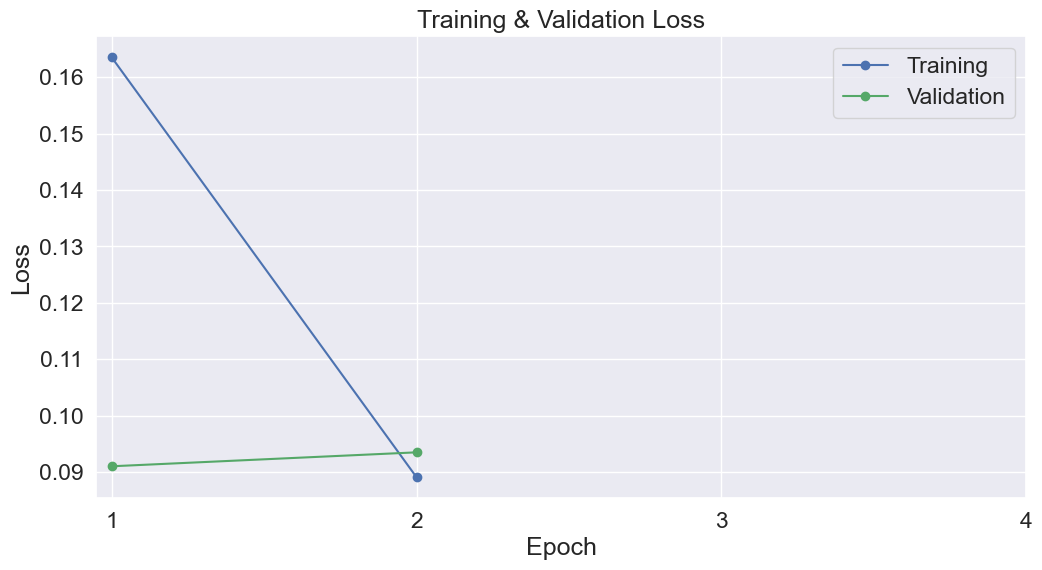

In [28]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

An **underfit** model can be identified from the learning curve of the training loss only.

It may show a flat line or noisy values of relatively high loss, indicating that the model was unable to learn the training dataset at all.

An example of this is provided below and is common when the model does not have a suitable capacity for the complexity of the dataset.

A plot of learning curves shows **underfitting** if:

- The training loss remains flat regardless of training.
- The training loss continues to decrease until the end of training.

A plot of learning curves shows **overfitting** if:

- The plot of training loss continues to decrease with experience.
- The plot of validation loss decreases to a point and begins increasing again.

A plot of learning curves shows a **good** fit if:

- The plot of training loss decreases to a point of stability.
- The plot of validation loss decreases to a point of stability and has a small gap with the training loss.

## LOADING BEST MODEL

In [29]:
model = torch.load('bert_model_bbc')

## TEST PERFORMANCE

In [30]:
# Create sentence and label lists
sentences = test_df.text.values
labels = test_df.label.values


# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

c:\Users\Leo\.conda\envs\bert\lib\site-packages\transformers\tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [31]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 235,994 test sentences...
    DONE.


In [32]:
from functools import reduce
scores = reduce(lambda x,y: x+y,[list(map(np.argmax,p)) for p in predictions])
labels = reduce(lambda x,y: list(x) + list(y), true_labels)

from sklearn.metrics import accuracy_score
accuracy_score(scores, labels)

0.940290854852242

## CONFUSION MATRIX

In [33]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

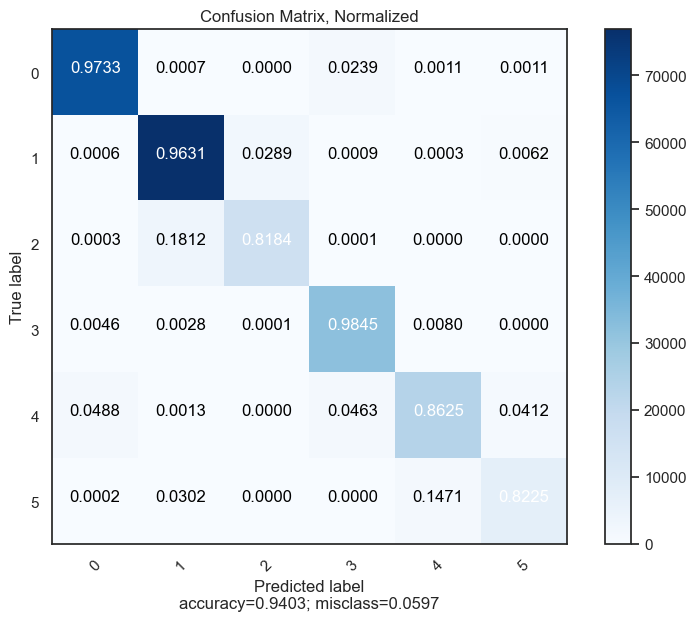

In [34]:
from sklearn.metrics import confusion_matrix

sns.set(font_scale=1)
sns.set(style='white')


cm = confusion_matrix(labels,scores)
plot_confusion_matrix(cm           = cm, 
                      normalize    = True,
                      target_names = ['0', '1', '2','3','4','5'],
                      title        = "Confusion Matrix, Normalized")